In [1]:
import scipy as scipy
import matplotlib.pyplot as plt
import numpy as np

import h5py
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, ReLU, GlobalAveragePooling2D, Reshape, Dense, multiply, Add, Concatenate, Lambda
from tensorflow.keras.utils import plot_model

import helper
from helper import exec_time_and_y_pred

2025-02-16 14:25:38.205334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 14:25:38.232232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 14:25:38.238846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 14:25:38.264351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-16 14:25:39.674274: W tensorflow/comp

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2025-02-16 14:25:42.018175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31139 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:23:00.0, compute capability: 7.0


In [3]:
folder = "../dataset_train_val/"
filename = "dataset_train_val_challenge_5.npz"
fullpath = folder+filename

In [4]:
data = np.load(fullpath)

In [5]:
# Access arrays by their keys
trainData_train = data["trainData_train"]
trainLabels_train = data["trainLabels_train"]
trainPractical_train = data["trainPractical_train"]
trainLinearInterpolation_train = data["trainLinearInterpolation_train"]
otherLabels_train = data["otherLabels_train"]

trainData_validation = data["trainData_validation"]
trainLabels_validation = data["trainLabels_validation"]
trainPractical_validation = data["trainPractical_validation"]
trainLinearInterpolation_validation = data["trainLinearInterpolation_validation"]
otherLabels_validation = data["otherLabels_validation"]

In [6]:
# Print shapes to verify
print("Training Data shape:", trainData_train.shape)
print("Validation Data shape:", trainData_validation.shape)

Training Data shape: (394, 612, 14, 2)
Validation Data shape: (84, 612, 14, 2)


In [7]:
def SRCNN(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (9, 9), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    outputs = Conv2D(2, (5, 5), padding='same', activation='linear')(x)
    model = Model(inputs, outputs, name="SRCNN")
    return model

def DnCNN(input_shape, depth=17, num_filters=64):
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(inputs)

    for _ in range(1, depth-1):
        x = Conv2D(num_filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    outputs = Conv2D(input_shape[-1], (3, 3), padding='same')(x)

    # Residual Learning: output the noise, then subtract it from input to get denoised image
    outputs = Add()([inputs, outputs])

    model = Model(inputs, outputs, name="DnCNN")
    return model

In [8]:
input_shape = (612, 14, 2)  # Example input shape

# Step 1: Train the SRCNN Model
srcnn_model = SRCNN(input_shape)
srcnn_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
srcnn_model.summary()

Model: "SRCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 612, 14, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 612, 14, 64)    │        10,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 612, 14, 32)    │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 612, 14, 2)     │         1,602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,114 (55.13 KB)

 Trainable params: 14,114 (55.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#model name
model_type = 'srcnn_1024'
timenow = datetime.now().strftime("%H%M%S%d%m%y")
model_filename_srcnn = f'{timenow}_{model_type}_best_classifier_model.keras'

In [10]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
classifier_checkpoint = ModelCheckpoint(model_filename_srcnn, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=40, min_lr=0.00001)

In [11]:
## Train the SRCNN part
srcnn_model.fit(trainData_train, trainLabels_train,
          epochs=2,
          batch_size=64,
          shuffle=True,
          validation_data=(trainData_validation, trainLabels_validation),
          callbacks=[early_stopping, classifier_checkpoint, reduce_lr])

Epoch 1/2


I0000 00:00:1739715946.570550   79150 service.cc:146] XLA service 0x7fc060046530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739715946.570956   79150 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2025-02-16 14:25:46.665735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-16 14:25:46.854579: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4462 - mae: 0.5179

I0000 00:00:1739715948.931499   79150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - loss: 0.3805 - mae: 0.4687 - val_loss: 0.1087 - val_mae: 0.2492 - learning_rate: 0.0010
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1034 - mae: 0.2394 - val_loss: 0.0750 - val_mae: 0.2024 - learning_rate: 0.0010


In [12]:
srcnn_model = load_model(model_filename_srcnn)

In [13]:
# Step 2: Freeze the SRCNN Model and Train the DnCNN Model
for layer in srcnn_model.layers:
    layer.trainable = False

inputs = Input(shape=input_shape)
sr_output = srcnn_model(inputs)

dncnn_model = DnCNN(sr_output.shape[1:])
final_output = dncnn_model(sr_output)

channelnet_model = Model(inputs, final_output, name="ChannelNet")
channelnet_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
channelnet_model.summary()

Model: "ChannelNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 612, 14, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SRCNN (Functional)              │ (None, 612, 14, 2)     │        14,114 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DnCNN (Functional)              │ (None, 612, 14, 2)     │       560,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,244 (2.19 MB)

 Trainable params: 558,210 (2.13 MB)

 Non-trainable params: 16,034 (62.63 KB)

In [14]:
#model name
model_type = 'channelnet_1024'
timenow = datetime.now().strftime("%H%M%S%d%m%y")
model_filename_channelnet = f'{timenow}_{model_type}_best_classifier_model.keras'

In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
classifier_checkpoint = ModelCheckpoint(model_filename_channelnet, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=25, min_lr=0.00001)

In [16]:
###### Train ChannelNet (SRCNN + DnCNN)
channelnet_model.fit(trainData_train, trainLabels_train,
          epochs=2,
          batch_size=64,
          shuffle=True,
          validation_data=(trainData_validation, trainLabels_validation),
          callbacks=[early_stopping, classifier_checkpoint, reduce_lr])

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.5854 - mae: 0.4769 - val_loss: 0.0722 - val_mae: 0.1986 - learning_rate: 0.0010
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0800 - mae: 0.2070 - val_loss: 0.0737 - val_mae: 0.2012 - learning_rate: 0.0010


In [17]:
model = load_model(model_filename_channelnet)

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
#Calculate execution time
total_time_se, time_per_sample_se, y_pred = exec_time_and_y_pred(model, trainData_validation)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


In [19]:
print(f"Total execution time: {total_time_se:.6f} seconds")
print(f"Execution time per sample: {time_per_sample_se:.6f} seconds")

Total execution time: 5.180908 seconds
Execution time per sample: 0.061677 seconds


In [20]:
print("CNN")
first_dimension = trainLabels_validation.shape[0]
cnn_mse = mean_squared_error(trainLabels_validation.reshape(first_dimension,-1), y_pred.reshape(first_dimension,-1))
cnn_mae = mean_absolute_error(trainLabels_validation.reshape(first_dimension,-1), y_pred.reshape(first_dimension,-1))
cnn_r2 = r2_score(trainLabels_validation.reshape(first_dimension,-1), y_pred.reshape(first_dimension,-1))
print("MSE: %.4f" % cnn_mse)
print("MAE: %.4f" % cnn_mae)
print('R²: %.4f' % cnn_r2)

CNN
MSE: 0.0722
MAE: 0.1986
R²: 0.8229


In [21]:
print("Practical CE")
practical_mse =  mean_squared_error(trainLabels_validation.reshape(first_dimension,-1), trainPractical_validation.reshape(first_dimension,-1))
practical_mae = mean_absolute_error(trainLabels_validation.reshape(first_dimension,-1), trainPractical_validation.reshape(first_dimension,-1))
practical_r2 =  r2_score(trainLabels_validation.reshape(first_dimension,-1), trainPractical_validation.reshape(first_dimension,-1))

print("MSE: %.4f" % practical_mse)
print("MAE: %.4f" % practical_mae)
print('R²: %.4f' % practical_r2)

Practical CE
MSE: 0.0279
MAE: 0.1148
R²: 0.9305


In [22]:
print("Linear CE")
mse_linear = mean_squared_error(trainLabels_validation.reshape(first_dimension,-1), trainLinearInterpolation_validation.reshape(first_dimension,-1))
mae_linear = mean_absolute_error(trainLabels_validation.reshape(first_dimension,-1), trainLinearInterpolation_validation.reshape(first_dimension,-1))
r2_linear = r2_score(trainLabels_validation.reshape(first_dimension,-1), trainLinearInterpolation_validation.reshape(first_dimension,-1))
print("MSE: %.4f" % mse_linear)
print("MAE: %.4f" % mae_linear)
print('R²: %.4f' % r2_linear)

Linear CE
MSE: 0.1993
MAE: 0.2610
R²: 0.5073


In [23]:
print("Comparing and improvement")
print(f'CNN MSE: {cnn_mse}, Practical: {practical_mse}, Linear: {mse_linear}')
print(f'CNN vs. Linear MSE {(mse_linear-cnn_mse)*100/mse_linear}, CNN vs. Practical {(practical_mse-cnn_mse)*100/practical_mse}')

Comparing and improvement
CNN MSE: 0.07222192017574788, Practical: 0.027929328106597748, Linear: 0.19930684842513324
CNN vs. Linear MSE 63.76345281337535, CNN vs. Practical -158.58810459062525


In [24]:
# Generate a random index
#random_index = np.random.randint(0, trainData_validation.shape[0])
random_index = 8
input_sample = trainData_validation[random_index]
label_sample = trainLabels_validation[random_index]
practical_sample = trainPractical_validation[random_index]
linearInterpol_sample = trainLinearInterpolation_validation[random_index]
predicted_sample = model.predict(np.expand_dims(input_sample, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


In [25]:
# Compute the magnitude using the absolute value of the last dimension
input_magnitude = np.linalg.norm(input_sample, axis=-1)
label_magnitude = np.linalg.norm(label_sample, axis=-1)
practical_magnitude = np.linalg.norm(practical_sample, axis=-1)
linearInterpol_magnitude = np.linalg.norm(linearInterpol_sample, axis=-1)
predicted_magnitude = np.linalg.norm(predicted_sample, axis=-1)

In [26]:
cmax = np.max(np.concatenate((np.abs(label_magnitude), np.abs(practical_magnitude), np.abs(predicted_magnitude)), axis=0))
cmin = np.min(np.concatenate((np.abs(label_magnitude), np.abs(practical_magnitude), np.abs(linearInterpol_magnitude), np.abs(predicted_magnitude)), axis=0))

In [27]:
# Calculate the Mean Squared Error
mse_linear = np.mean((label_sample - linearInterpol_sample) ** 2)
print(f'MSE Linear: {mse_linear}')

mse_prac = np.mean((label_sample - practical_sample) ** 2)
print(f'MSE CE practical: {mse_prac}')

# Calculate the Mean Squared Error
mse_nn = np.mean((label_sample - predicted_sample) ** 2)
print(f'MSE DNN: {mse_nn}')

MSE Linear: 0.04128833058871371
MSE CE practical: 0.018847764624689844
MSE DNN: 0.059812305662517086


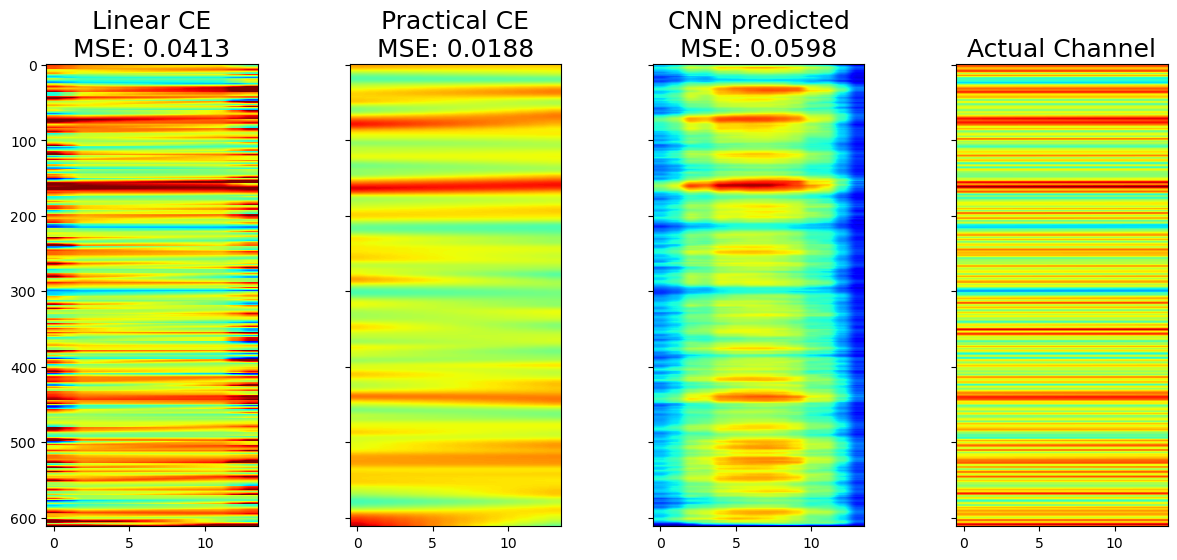

In [28]:
# Plotting
#cmap = parula_colormap
cmap = "jet"
font_size = 18
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)

axs[0].imshow(np.abs(linearInterpol_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[0].set_aspect(0.05)
axs[0].set_title(f'Linear CE\nMSE: {mse_linear:.4f}',fontsize=font_size)

axs[1].imshow(np.abs(practical_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[1].set_aspect(0.05)
axs[1].set_title(f'Practical CE\nMSE: {mse_prac:.4f}',fontsize=font_size)

axs[2].imshow(np.abs(predicted_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[2].set_aspect(0.05)
axs[2].set_title(f'CNN predicted\nMSE: {mse_nn:.4f}',fontsize=font_size)

axs[3].imshow(np.abs(label_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[3].set_aspect(0.05)
axs[3].set_title('Actual Channel',fontsize=font_size)

plt.show()

In [29]:
# Unique SNR values
unique_snr_values, unique_snr_counts = np.unique(otherLabels_validation[:, 1], return_counts=True)

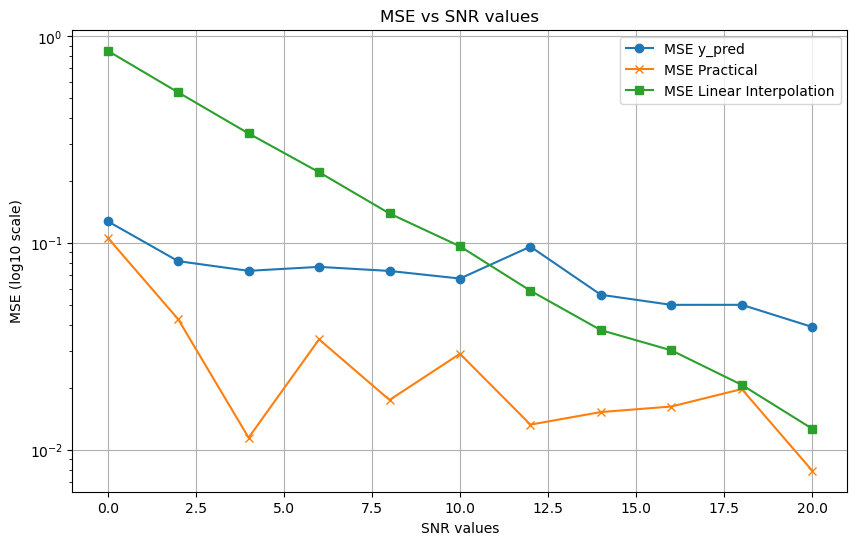

In [30]:
# Calculate MSE for each SNR value
mse_results = {
    "SNR": [],
    "MSE_y_pred": [],
    "MSE_practical": [],
    "MSE_linear_interpolation": []
}

for snr, idx in zip(unique_snr_values, unique_snr_counts):
    indices = otherLabels_validation[:, 1] == snr

    # Determine the first dimension for reshaping
    first_dimension = idx

    mse_y_pred = mean_squared_error(
        trainLabels_validation[indices].reshape(first_dimension, -1),
        y_pred[indices].reshape(first_dimension, -1)
    )
    mse_practical = mean_squared_error(
        trainLabels_validation[indices].reshape(first_dimension, -1),
        trainPractical_validation[indices].reshape(first_dimension, -1)
    )
    mse_linear_interpolation = mean_squared_error(
        trainLabels_validation[indices].reshape(first_dimension, -1),
        trainLinearInterpolation_validation[indices].reshape(first_dimension, -1)
    )

    mse_results["SNR"].append(snr)
    mse_results["MSE_y_pred"].append(mse_y_pred)
    mse_results["MSE_practical"].append(mse_practical)
    mse_results["MSE_linear_interpolation"].append(mse_linear_interpolation)

# Plotting the results with log10 scale for y-axis
plt.figure(figsize=(10, 6))
plt.plot(mse_results["SNR"], mse_results["MSE_y_pred"], label="MSE y_pred", marker='o')
plt.plot(mse_results["SNR"], mse_results["MSE_practical"], label="MSE Practical", marker='x')
plt.plot(mse_results["SNR"], mse_results["MSE_linear_interpolation"], label="MSE Linear Interpolation", marker='s')
plt.xlabel("SNR values")
plt.ylabel("MSE (log10 scale)")
plt.yscale('log')
plt.title("MSE vs SNR values")
plt.legend()
plt.grid(True)
plt.show()